In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!apt-get install -y unzip >/dev/null

# 這裡是你雲端上的 zip 路徑，如果你放在子資料夾，路徑記得改
ZIP_PATH = "/content/drive/MyDrive/csiro-biomass.zip"

# 解壓到 Colab 本機
TARGET_DIR = "/content/csiro-biomass"
!unzip -o -q "$ZIP_PATH" -d "$TARGET_DIR"

# 看一下解壓後內容
!ls -R "$TARGET_DIR"

/content/csiro-biomass:
sample_submission.csv  test  test.csv  train  train.csv

/content/csiro-biomass/test:
ID1001187975.jpg

/content/csiro-biomass/train:
ID1011485656.jpg  ID1463690813.jpg  ID196516535.jpg   ID574213894.jpg
ID1012260530.jpg  ID146920896.jpg   ID1970522802.jpg  ID576137678.jpg
ID1025234388.jpg  ID1471216911.jpg  ID1976436386.jpg  ID576621307.jpg
ID1028611175.jpg  ID1472525822.jpg  ID1980675327.jpg  ID577112774.jpg
ID1035947949.jpg  ID1473228876.jpg  ID1982662138.jpg  ID587125778.jpg
ID1036339023.jpg  ID1474775613.jpg  ID1988033238.jpg  ID588120964.jpg
ID1049634115.jpg  ID147528735.jpg   ID1989506559.jpg  ID600602588.jpg
ID1051144034.jpg  ID1476045099.jpg  ID1993907137.jpg  ID605134229.jpg
ID1052620238.jpg  ID1477176296.jpg  ID1997244125.jpg  ID610397481.jpg
ID105271783.jpg   ID1488408526.jpg  ID2002797732.jpg  ID617132135.jpg
ID1053972079.jpg  ID1496750796.jpg  ID2003438517.jpg  ID61833032.jpg
ID1058383417.jpg  ID1498398599.jpg  ID2006686196.jpg  ID6269659.jpg
ID106

In [ ]:
import os
import cv2
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from prettytable import PrettyTable
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import timm

!pip install grad-cam
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image
    HAS_GRADCAM = True
except ImportError:
    HAS_GRADCAM = False
    print("Warning: grad-cam not installed. Visualization might fail.")

# ==========================================
# 全局設定
# ==========================================
BASE_DIR = '/content/csiro-biomass'
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_CSV_PATH = os.path.join(BASE_DIR, 'test.csv')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print(f"Using device: {DEVICE}")
print(f"Versions - Torch: {torch.__version__}, NP: {np.__version__}")

# 反標準化工具 (用於顯示圖片)
def inverse_normalize(tensor):
    """將 Normalize 過的 tensor (C,H,W) 還原回 0~1 RGB numpy (H,W,C)"""
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    if tensor.dim() == 3:
        img = tensor.permute(1, 2, 0).cpu().numpy()
    elif tensor.dim() == 4: # batch
        img = tensor[0].permute(1, 2, 0).cpu().numpy()

    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img.astype(np.float32)

Using device: cuda
Versions - Torch: 2.9.0+cu126, NP: 2.0.2


In [45]:
# ==========================================
# 2.1 資料清理函式
# ==========================================
def preprocess_data(df, is_train=True, train_stats=None):
    df = df.copy()

    # 補齊測試集缺失欄位
    if not is_train and train_stats:
        required_cols = ['Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']
        for col in required_cols:
            if col not in df.columns:
                df[col] = train_stats[col]

    # 處理日期
    df['Sampling_Date'] = pd.to_datetime(df['Sampling_Date'])
    df['Month'] = df['Sampling_Date'].dt.month

    meta_cols = ['image_path', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Month']
    # 轉為 Wide Format
    df_wide = df[meta_cols].drop_duplicates(subset=['image_path']).reset_index(drop=True)

    targets = None
    if is_train:
        targets = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
        for t in targets:
            temp = df[df['target_name'] == t][['image_path', 'target']].rename(columns={'target': t})
            df_wide = df_wide.merge(temp, on='image_path', how='left')

    return df_wide, targets

# ==========================================
# 2.2 執行預處理
# ==========================================
train_df_raw = pd.read_csv(TRAIN_CSV_PATH)
test_df_raw = pd.read_csv(TEST_CSV_PATH)

# 計算訓練集統計量供測試集補值用
train_stats = {}
for col in ['Sampling_Date', 'State', 'Species']:
    train_stats[col] = train_df_raw[col].mode()[0]
for col in ['Pre_GSHH_NDVI', 'Height_Ave_cm']:
    train_stats[col] = train_df_raw[col].mean()

train_df, target_cols = preprocess_data(train_df_raw, is_train=True)
test_df, _ = preprocess_data(test_df_raw, is_train=False, train_stats=train_stats)

# 編碼與標準化
cat_cols = ['State', 'Species']
num_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm', 'Month']

for col in cat_cols:
    le = LabelEncoder()
    full_list = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(full_list)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

print(f"Data Prepared. Train: {train_df.shape}, Test: {test_df.shape}")

# ==========================================
# 2.3 Dataset 定義
# ==========================================
class PastureDataset(Dataset):
    def __init__(self, df, root_dir, transforms=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transforms = transforms
        self.target_cols = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["image_path"])
        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # 測試集模式
        if self.target_cols is None:
            return image

        # 訓練模式
        target = self.df.loc[idx, self.target_cols].values.astype("float32")
        return image, torch.tensor(target)

class MTLDataset(Dataset):
    """ 用於 Multi-Task Learning，額外回傳 Mask """
    def __init__(self, original_dataset, masks):
        self.dataset = original_dataset
        self.masks = masks # numpy array (N, 224, 224)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        mask = self.masks[idx]
        mask = torch.tensor(mask).unsqueeze(0) # (1, 224, 224)
        return img, target, mask

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Data Prepared. Train: (357, 11), Test: (1, 6)


In [46]:
# --- 1. Soft Mask Attention 模組 ---
class SoftMaskAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.mask_net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.last_mask = None

    def forward(self, x):
        mask = self.mask_net(x)
        self.last_mask = mask
        return x * mask, mask

# --- 2. MTL Segmentation Decoder 模組 ---
class SegDecoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 14
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),         # 28
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),           # 56
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),            # 112
            nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid()                               # 224
        )

    def forward(self, x):
        return self.layers(x)

# --- 3. 主模型 ---
class PastureAblationModel(nn.Module):
    def __init__(self, n_outputs=1, use_soft_mask=False, use_mtl=False):
        super().__init__()
        self.use_soft_mask = use_soft_mask
        self.use_mtl = use_mtl

        # Backbone
        self.cnn = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='')
        self.n_features = 1280

        # Soft Mask
        if self.use_soft_mask:
            self.attention = SoftMaskAttention(self.n_features)

        # MTL Decoder
        if self.use_mtl:
            self.seg_decoder = SegDecoder(self.n_features)

        # Regression Head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.reg_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.n_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_outputs)
        )

    def forward(self, x, return_viz=False):
        features = self.cnn(x) # (B, 1280, 7, 7)

        soft_mask = None
        seg_output = None

        features_for_reg = features
        if self.use_soft_mask:
            features_for_reg, soft_mask = self.attention(features)

        if self.use_mtl:
            seg_output = self.seg_decoder(features)

        pooled = self.global_pool(features_for_reg)
        pred_biomass = self.reg_head(pooled)

        if return_viz:
            return {'pred': pred_biomass, 'soft_mask': soft_mask, 'seg_mask': seg_output}

        if self.use_mtl:
            return pred_biomass, seg_output
        else:
            return pred_biomass

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate(
    model,
    train_loader,
    val_loader,
    device,
    epochs=10,
    experiment_name="Exp",
    lambda_seg=0.3 
):
    print(f"\nStarting Experiment: {experiment_name}")

    # 先定義 optimizer
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    # 再定義 scheduler（用 val_loss 控制 lr）
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,     # 每次下降一半
        patience=3,     # 連續 3 個 epoch 沒變好才降
    )

    criterion_main = nn.MSELoss()
    criterion_seg  = nn.BCELoss()   # 因為 seg_decoder 最後一層是 Sigmoid，所以用 BCELoss

    history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_r2': []}

    model.to(device)

    for epoch in range(epochs):
        # ============================
        # Training Phase
        # ============================
        model.train()
        train_losses = []

        for batch in train_loader:
            # batch 可能是 (img, target) 或 (img, target, mask)
            if len(batch) == 3:
                inputs, targets, masks = batch
                masks = masks.to(device)           # (B, 1, 224, 224)
            else:
                inputs, targets = batch
                masks = None                       # 代表這個實驗沒有 MTL

            inputs, targets = inputs.to(device), targets.to(device)
            target_vals = targets[:, 4].float().view(-1, 1)  # GDM_g

            optimizer.zero_grad()

            outputs = model(inputs) 

            # --- 拆解輸出 ---
            if isinstance(outputs, tuple):
                pred_main, pred_seg = outputs      # pred_seg: (B, 1, 224, 224)
            else:
                pred_main = outputs
                pred_seg = None

            # --- 主任務輸出維度修正 ---
            if pred_main.shape[1] > 1 and target_vals.shape[1] == 1:
                pred_main = pred_main[:, 0:1]

            # --- 主任務 Loss ---
            loss_main = criterion_main(pred_main, target_vals)

            # --- Segmentation Loss（只有 use_mtl + 有 mask 時才啟用） ---
            use_seg_loss = (
                hasattr(model, "use_mtl")
                and model.use_mtl
                and (pred_seg is not None)
                and (masks is not None)
            )

            if use_seg_loss:
                # pred_seg, masks 都是 (B,1,224,224)，值域 0~1
                loss_seg = criterion_seg(pred_seg, masks)
                loss = loss_main + lambda_seg * loss_seg
            else:
                loss = loss_main

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # ============================
        # Validation Phase
        # ============================
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    inputs, targets, masks = batch
                    masks = masks.to(device)
                else:
                    inputs, targets = batch
                    masks = None

                inputs, targets = inputs.to(device), targets.to(device)
                target_vals = targets[:, 4].float().view(-1, 1)

                outputs = model(inputs)

                if isinstance(outputs, tuple):
                    pred_main, pred_seg = outputs
                else:
                    pred_main = outputs
                    pred_seg = None

                if pred_main.shape[1] > 1 and target_vals.shape[1] == 1:
                    pred_main = pred_main[:, 0:1]

                loss_main = criterion_main(pred_main, target_vals)

                use_seg_loss = (
                    hasattr(model, "use_mtl")
                    and model.use_mtl
                    and (pred_seg is not None)
                    and (masks is not None)
                )
                if use_seg_loss:
                    loss_seg = criterion_seg(pred_seg, masks)
                    val_loss = loss_main + lambda_seg * loss_seg
                else:
                    val_loss = loss_main

                val_losses.append(val_loss.item())

                all_preds.extend(pred_main.cpu().numpy())
                all_targets.extend(target_vals.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        all_targets = np.array(all_targets)
        all_preds = np.array(all_preds)

        val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        val_r2 = r2_score(all_targets, all_preds)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_r2'].append(val_r2)

        # 在這裡用 val_loss 驅動 scheduler
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {avg_train_loss:.4f} / {avg_val_loss:.4f} | "
              f"Val RMSE: {val_rmse:.4f} | Val R2: {val_r2:.4f}")

    return model, history

def generate_pseudo_masks(model, dataset, device='cuda'):
    """使用 Soft Mask 模型生成 Pseudo Masks"""
    print("Generating Pseudo Masks...")
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    model.eval()
    model.to(device)
    all_masks = []

    with torch.no_grad():
        for images in loader:
            # Dataset 若只回傳 tuple(image, target)
            if isinstance(images, list) or isinstance(images, tuple):
                images = images[0]

            images = images.to(device)
            out_dict = model(images, return_viz=True)
            masks = out_dict['soft_mask'] # (B, 1, 7, 7)

            masks_np = masks.cpu().numpy()
            for j in range(masks_np.shape[0]):
                m = masks_np[j, 0]
                m_resized = cv2.resize(m, (224, 224), interpolation=cv2.INTER_CUBIC)
                m_binary = (m_resized > 0.4).astype(np.float32)
                all_masks.append(m_binary)

    return np.array(all_masks)

In [50]:
!pip install grad-cam -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import cv2

try:
    HAS_GRADCAM
except NameError:
    try:
        from pytorch_grad_cam import GradCAM
        from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
        from pytorch_grad_cam.utils.image import show_cam_on_image
        HAS_GRADCAM = True
    except ImportError:
        HAS_GRADCAM = False
        print("警告: 未安裝 grad-cam，Grad-CAM 相關圖會顯示為全黑。")

def inverse_normalize(tensor):
    """
    將 ImageNet 標準化後的 Tensor [3, H, W] 還原成 0~1 RGB np.array [H, W, 3]
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = tensor.permute(1, 2, 0).detach().cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img.astype(np.float32)

def compute_exg_mask_numpy(rgb_img_np, threshold=0.4):
    """
    用 Excess Green (ExG) 做 pseudo mask:
    ExG = 2G - R - B，最後二值化成 0/1
    """
    r = rgb_img_np[:, :, 0]
    g = rgb_img_np[:, :, 1]
    b = rgb_img_np[:, :, 2]

    exg = 2 * g - r - b
    exg_norm = (exg - exg.min()) / (exg.max() - exg.min() + 1e-8)
    mask = (exg_norm > threshold).astype(np.float32)
    return mask

class ModelWrapperForGradCAM(torch.nn.Module):
    """讓 GradCAM 只看到 regression output，不管 tuple/dict 之類的複雜輸出"""
    def __init__(self, model, target_col_idx=4):
        super().__init__()
        self.model = model
        self.target_col_idx = target_col_idx

    def forward(self, x):
        out = self.model(x)
        # dict: {'pred': pred, ...}
        if isinstance(out, dict):
            pred = out['pred']
        # tuple: (pred, seg) 或 (pred, something)
        elif isinstance(out, tuple):
            pred = out[0]
        else:
            pred = out
        return pred


def visualize_analysis_1x6(model, dataset, idx, device, target_col_idx=4):
    """
    畫出：
    1) Original Image
    2) Pseudo Mask (ExG)
    3) Learned Soft Mask
    4) Soft Mask Overlay (Img * Mask)
    5) Grad-CAM Heatmap
    6) Grad-CAM Overlay
    """
    model.eval()
    model.to(device)

    # -------- 1. 取出資料 --------
    img_tensor, target = dataset[idx]      # img: [3,H,W], target: [5]
    img_input = img_tensor.unsqueeze(0).to(device)
    H, W = img_tensor.shape[1], img_tensor.shape[2]

    original_img = inverse_normalize(img_tensor)   # [H,W,3], 0~1
    true_val = float(target[target_col_idx].item())

    # -------- 2. 模型 forward：拿 pred + soft mask --------
    soft_mask_tensor = None
    pred_val = None

    with torch.no_grad():
        try:
            out = model(img_input, return_viz=True)
        except TypeError:
            out = model(img_input)

        if isinstance(out, dict):  
            pred = out['pred']
            soft_mask_tensor = out.get('soft_mask', None)
        elif isinstance(out, tuple):
            pred = out[0]
        else:
            pred = out

        if pred.ndim == 2 and pred.shape[1] > 1:
            pred_val = float(pred[0, target_col_idx].item())
        else:
            pred_val = float(pred[0].item())

    # -------- 3. Pseudo Mask (ExG) --------
    pseudo_mask_np = compute_exg_mask_numpy(original_img)   # [H,W]

    # -------- 4. Learned Soft Mask & Overlay --------
    if soft_mask_tensor is not None:
        # soft_mask_tensor: [B,1,h,w] → 上採樣到 [H,W]
        learned_mask_up = F.interpolate(
            soft_mask_tensor, size=(H, W),
            mode="bilinear", align_corners=False
        )
        learned_mask_np = learned_mask_up[0, 0].detach().cpu().numpy()
        # normalize 到 0~1
        learned_mask_np = (learned_mask_np - learned_mask_np.min()) / \
                          (learned_mask_np.max() - learned_mask_np.min() + 1e-8)
    else:
        learned_mask_np = np.zeros((H, W), dtype=np.float32)

    # Soft Mask Overlay: 原圖 * mask
    soft_overlay_np = original_img * learned_mask_np[..., None]
    soft_overlay_np = np.clip(soft_overlay_np * 1.5, 0, 1)  

    # -------- 5. Grad-CAM Heatmap & Overlay --------
    if HAS_GRADCAM and hasattr(model, "cnn") and hasattr(model.cnn, "conv_head"):
        target_layer = model.cnn.conv_head
        wrapper = ModelWrapperForGradCAM(model, target_col_idx=target_col_idx)
        # cam = GradCAM(model=wrapper, target_layers=[target_layer], use_cuda=(device.type == "cuda"))
        cam = GradCAM(model=wrapper, target_layers=[target_layer])
        targets = [ClassifierOutputTarget(target_col_idx)]

        grayscale_cam = cam(input_tensor=img_input, targets=targets)[0]  # [H,W] after resize by GradCAM
        gradcam_heatmap = grayscale_cam
        gradcam_overlay = show_cam_on_image(original_img, gradcam_heatmap, use_rgb=True)
    else:
        gradcam_heatmap = np.zeros((H, W), dtype=np.float32)
        gradcam_overlay = np.zeros_like(original_img)

    # -------- 6. 畫 1x6 圖 --------
    fig, axes = plt.subplots(1, 6, figsize=(22, 4))

    # 1) Original
    axes[0].imshow(original_img)
    axes[0].set_title("1) Original")
    axes[0].axis("off")

    # 2) Pseudo Mask (ExG)
    axes[1].imshow(pseudo_mask_np, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("2) Pseudo Mask (ExG)")
    axes[1].axis("off")

    # 3) Learned Soft Mask
    im3 = axes[2].imshow(learned_mask_np, cmap="jet", vmin=0, vmax=1)
    axes[2].set_title("3) Learned Soft Mask")
    axes[2].axis("off")

    # 4) Soft Mask Overlay
    axes[3].imshow(soft_overlay_np)
    axes[3].set_title("4) Soft Mask Overlay")
    axes[3].axis("off")

    # 5) Grad-CAM Heatmap
    axes[4].imshow(gradcam_heatmap, cmap="jet", vmin=0, vmax=1)
    axes[4].set_title("5) Grad-CAM Heatmap")
    axes[4].axis("off")

    # 6) Grad-CAM Overlay
    axes[5].imshow(gradcam_overlay)
    axes[5].set_title("6) Grad-CAM Overlay")
    axes[5].axis("off")

    plt.suptitle(f"Idx: {idx} | Truth: {true_val:.2f} | Pred: {pred_val:.2f}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [53]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 切分資料
train_split, val_split = train_test_split(train_df, test_size=0.2, random_state=42)

# 建立 Dataset
train_ds = PastureDataset(train_split, root_dir=BASE_DIR, transforms=train_transforms, target_cols=target_cols)
val_ds = PastureDataset(val_split, root_dir=BASE_DIR, transforms=val_transforms, target_cols=target_cols)

# 建立 Base DataLoader
train_loader_base = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader_base = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

print("DataLoader 準備完成，開始消融研究...")

DataLoader 準備完成，開始消融研究...


In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, exp_name=""):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(20, 5))

    # 1. Loss 圖 (MSE)
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', markersize=3)
    plt.plot(epochs_range, history['val_loss'], label='Val Loss', marker='o', markersize=3)
    plt.title(f'[{exp_name}] Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 2. RMSE 圖
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['val_rmse'], label='Val RMSE', color='orange', marker='o', markersize=3)
    plt.title(f'[{exp_name}] Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 3. R2 Score 圖
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['val_r2'], label='Val R2', color='green', marker='o', markersize=3)
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.3, label='Perfect (1.0)')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.3, label='Baseline (0.0)')
    plt.title(f'[{exp_name}] Validation R2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [ ]:
import random

EPOCHS = 50
RESULTS_TABLE = []

# 視覺化要用哪個 dataset
dataset_to_use = val_ds  
# 為了公平比較，四個模型都用同一張圖
idx_vis = random.randint(0, len(dataset_to_use) - 1)
print(f"All 1x6 visualizations will use sample idx = {idx_vis}")

# --- Exp 1: Baseline ---
model_base = PastureAblationModel(use_soft_mask=False, use_mtl=False)
model_base, hist_base = train_and_evaluate(model_base, train_loader_base, val_loader_base, DEVICE,
                                           epochs=EPOCHS, experiment_name="1_Baseline")

# --- Exp 2: Soft Mask ---
model_soft = PastureAblationModel(use_soft_mask=True, use_mtl=False)
model_soft, hist_soft = train_and_evaluate(model_soft, train_loader_base, val_loader_base, DEVICE,
                                           epochs=EPOCHS, experiment_name="2_SoftMask")

# --- 產生 pseudo masks（用 SoftMask 模型）---
train_masks = generate_pseudo_masks(model_soft, train_ds, device=DEVICE)
val_masks   = generate_pseudo_masks(model_soft, val_ds,   device=DEVICE)

train_ds_mtl = MTLDataset(train_ds, train_masks)
val_ds_mtl   = MTLDataset(val_ds,   val_masks)

train_loader_mtl = DataLoader(train_ds_mtl, batch_size=32, shuffle=True,  num_workers=2)
val_loader_mtl   = DataLoader(val_ds_mtl,   batch_size=32, shuffle=False, num_workers=2)

# --- Exp 3: MTL Only ---
model_mtl = PastureAblationModel(use_soft_mask=False, use_mtl=True)
model_mtl, hist_mtl = train_and_evaluate(
    model_mtl,
    train_loader_mtl,
    val_loader_mtl,
    DEVICE,
    epochs=EPOCHS,
    experiment_name="3_MTL",
    lambda_seg=0.3   
)

# --- Exp 4: Full (SMA + MTL) ---
model_full = PastureAblationModel(use_soft_mask=True, use_mtl=True)
model_full, hist_full = train_and_evaluate(
    model_full,
    train_loader_mtl,
    val_loader_mtl,
    DEVICE,
    epochs=EPOCHS,
    experiment_name="4_Full",
    lambda_seg=0.3
)


All 1x6 visualizations will use sample idx = 35

Starting Experiment: 1_Baseline
Epoch 1/50 | Loss: 1710.4056 / 1149.7225 | Val RMSE: 36.6927 | Val R2: -1.7996
Epoch 2/50 | Loss: 1298.6568 / 578.8575 | Val RMSE: 25.5227 | Val R2: -0.3545
Epoch 3/50 | Loss: 872.2696 / 692.5153 | Val RMSE: 28.2462 | Val R2: -0.6590
Epoch 4/50 | Loss: 616.1175 / 329.7748 | Val RMSE: 19.0709 | Val R2: 0.2437
Epoch 5/50 | Loss: 496.3653 / 371.9947 | Val RMSE: 19.9781 | Val R2: 0.1701
Epoch 6/50 | Loss: 404.8547 / 349.7103 | Val RMSE: 19.7061 | Val R2: 0.1925
Epoch 7/50 | Loss: 390.8891 / 304.3450 | Val RMSE: 17.9320 | Val R2: 0.3314
Epoch 8/50 | Loss: 278.7532 / 239.7883 | Val RMSE: 16.1261 | Val R2: 0.4593
Epoch 9/50 | Loss: 254.2683 / 225.4747 | Val RMSE: 15.4583 | Val R2: 0.5031
Epoch 10/50 | Loss: 195.0941 / 235.8378 | Val RMSE: 16.0640 | Val R2: 0.4634
Epoch 11/50 | Loss: 195.3366 / 299.4960 | Val RMSE: 18.4283 | Val R2: 0.2938
Epoch 12/50 | Loss: 195.6296 / 195.6605 | Val RMSE: 14.5429 | Val R2: 0.560

In [78]:
def count_params(model):
    """回傳模型可訓練參數量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

summary_table = []

summary_table.append({
    "Model": "Baseline",
    "Best RMSE": min(hist_base['val_rmse']),
    "Best R2": max(hist_base['val_r2']),
    "Params": count_params(model_base)
})

summary_table.append({
    "Model": "Soft Mask",
    "Best RMSE": min(hist_soft['val_rmse']),
    "Best R2": max(hist_soft['val_r2']),
    "Params": count_params(model_soft)
})

summary_table.append({
    "Model": "MTL",
    "Best RMSE": min(hist_mtl['val_rmse']),
    "Best R2": max(hist_mtl['val_r2']),
    "Params": count_params(model_mtl)
})

summary_table.append({
    "Model": "Full (SMA + MTL)",
    "Best RMSE": min(hist_full['val_rmse']),
    "Best R2": max(hist_full['val_r2']),
    "Params": count_params(model_full)
})

import pandas as pd
df_summary = pd.DataFrame(summary_table)
print(df_summary)


              Model  Best RMSE   Best R2    Params
0          Baseline  10.702406  0.761823   4335741
1         Soft Mask  10.129063  0.786659   4438302
2               MTL  11.680297  0.716310  10268702
3  Full (SMA + MTL)  10.769224  0.758840  10371263


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import cv2

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# --------------------------------------------------
# 1. 反標準化：Tensor -> 0~1 RGB numpy
# --------------------------------------------------
def inverse_normalize(tensor):
    """
    將 ImageNet Normalize 後的 tensor [3,H,W] 還原成 [H,W,3] 0~1
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = tensor.permute(1, 2, 0).detach().cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img.astype(np.float32)

# --------------------------------------------------
# 2. ExG Pseudo Mask
# --------------------------------------------------
def compute_exg_mask_numpy(rgb_img_np, threshold=0.4):
    """
    計算 Excess Green (ExG) Index 並二值化作為 Pseudo Mask
    rgb_img_np: [H,W,3], 0~1
    """
    r = rgb_img_np[:, :, 0]
    g = rgb_img_np[:, :, 1]
    b = rgb_img_np[:, :, 2]

    exg = 2 * g - r - b
    exg_norm = (exg - exg.min()) / (exg.max() - exg.min() + 1e-8)
    mask = (exg_norm > threshold).astype(np.float32)
    return mask

# --------------------------------------------------
# 3. Wrapper：處理 dict / tuple 輸出，讓 Grad-CAM 看「純 pred」
# --------------------------------------------------
class ModelWrapperForGradCAM(torch.nn.Module):
    """
    讓 Grad-CAM 只看到 regression output，不管 tuple/dict 之類的複雜輸出
    不在這裡切 target_col_idx，交給 target 物件處理
    """
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        # dict: {'pred': pred, ...}
        if isinstance(out, dict):
            pred = out['pred']
        # tuple: (pred, seg) 或 (pred, something)
        elif isinstance(out, tuple):
            pred = out[0]
        else:
            pred = out
        return pred  # 保持形狀 [B, n_outputs] 或 [B,1]

# --------------------------------------------------
# 4. 自訂 Regression Target：安全地取「要看的那一維」
# --------------------------------------------------
class RegressionTarget:
    def __init__(self, idx):
        self.idx = idx

    def __call__(self, model_output):
        # [B, C]
        if model_output.ndim == 2:
            b, c = model_output.shape
            j = min(self.idx, c - 1)  # 如果只有 1 維，就用最後一維
            return model_output[0, j]

        # [C]
        if model_output.ndim == 1:
            c = model_output.shape[0]
            j = min(self.idx, c - 1)
            return model_output[j]

        # 其他奇怪情況：攤平後取第一個
        return model_output.view(-1)[0]

# --------------------------------------------------
# 5. 主函式：1×6 視覺化
# --------------------------------------------------
def visualize_analysis_1x6(model, dataset, idx, device, target_col_idx=4):
    """
    產生 1x6 分析圖：
    1) Original Image
    2) Pseudo Mask (ExG)
    3) Learned Soft Mask (若沒有 SMA 就顯示黑圖)
    4) Soft Mask Overlay (Img * Mask)
    5) Grad-CAM Heatmap
    6) Grad-CAM Overlay
    """
    model.eval()
    model.to(device)

    # -------- 取資料 --------
    sample = dataset[idx]
    # val_ds 現在應該回傳 (img, target) 或 (img, target, mask)
    if len(sample) == 2:
        img_tensor, target_tensor = sample
    else:
        img_tensor, target_tensor = sample[0], sample[1]

    img_input = img_tensor.unsqueeze(0).to(device)   # [1,3,H,W]
    H, W = img_tensor.shape[1], img_tensor.shape[2]

    true_val = float(target_tensor[target_col_idx].item())

    # -------- forward，一次拿 pred + soft_mask --------
    with torch.no_grad():
        try:
            out = model(img_input, return_viz=True)
        except TypeError:
            # 模型沒有 return_viz 參數，就直接呼叫
            out = model(img_input)

    # 整理 pred
    if isinstance(out, dict):
        pred = out["pred"]
        soft_mask = out.get("soft_mask", None)
    elif isinstance(out, tuple):
        pred, maybe_seg = out[0], out[1] if len(out) > 1 else None
        # 這種情況通常沒有 soft_mask
        soft_mask = None
    else:
        pred = out
        soft_mask = None

    # pred shape 可能是 [B,1] 或 [B,5]
    if pred.ndim == 2:
        c = pred.shape[1]
        j = min(target_col_idx, c - 1)
        pred_val = float(pred[0, j].item())
    elif pred.ndim == 1:
        j = min(target_col_idx, pred.shape[0] - 1)
        pred_val = float(pred[j].item())
    else:
        pred_val = float(pred.view(-1)[0].item())

    # -------- 1) Original --------
    original_img = inverse_normalize(img_tensor)  # [H,W,3]

    # -------- 2) Pseudo Mask (ExG) --------
    pseudo_mask_np = compute_exg_mask_numpy(original_img)  # [H,W]

    # -------- 3) Learned Soft Mask (upsample 到 224x224) --------
    if soft_mask is not None:
        # soft_mask: [B,1,h,w] (例如 7x7)
        up = F.interpolate(soft_mask, size=(H, W), mode="bilinear", align_corners=False)
        learned_mask_np = up[0, 0].detach().cpu().numpy()
        # 正規化到 0~1
        learned_mask_np = (learned_mask_np - learned_mask_np.min()) / (learned_mask_np.max() - learned_mask_np.min() + 1e-8)
    else:
        learned_mask_np = np.zeros((H, W), dtype=np.float32)

    # -------- 4) Soft Mask Overlay (Img * Mask) --------
    soft_overlay_np = original_img * learned_mask_np[:, :, None]
    soft_overlay_np = np.clip(soft_overlay_np * 1.5, 0, 1)

    # -------- 5 & 6) Grad-CAM --------
    if hasattr(model, "cnn") and hasattr(model.cnn, "conv_head"):
        target_layer = model.cnn.conv_head
        wrapper = ModelWrapperForGradCAM(model)
        cam = GradCAM(
            model=wrapper,
            target_layers=[target_layer]
        )
        targets = [RegressionTarget(target_col_idx)]
        grayscale_cam = cam(input_tensor=img_input, targets=targets)[0]  # [H_cam, W_cam]

        # resize 成跟原圖一樣
        grayscale_cam = cv2.resize(grayscale_cam, (W, H))
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

        gradcam_overlay = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
    else:
        grayscale_cam = np.zeros((H, W), dtype=np.float32)
        gradcam_overlay = original_img.copy()

    # -------- 畫 1×6 圖 --------
    fig, axes = plt.subplots(1, 6, figsize=(22, 4))

    axes[0].imshow(original_img)
    axes[0].set_title("1) Original")
    axes[0].axis("off")

    axes[1].imshow(pseudo_mask_np, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("2) Pseudo Mask (ExG)")
    axes[1].axis("off")

    axes[2].imshow(learned_mask_np, cmap="jet", vmin=0, vmax=1)
    axes[2].set_title("3) Learned Soft Mask")
    axes[2].axis("off")

    axes[3].imshow(soft_overlay_np)
    axes[3].set_title("4) Soft Mask Overlay")
    axes[3].axis("off")

    axes[4].imshow(grayscale_cam, cmap="jet", vmin=0, vmax=1)
    axes[4].set_title("5) Grad-CAM Heatmap")
    axes[4].axis("off")

    axes[5].imshow(gradcam_overlay)
    axes[5].set_title("6) Grad-CAM Overlay")
    axes[5].axis("off")

    plt.suptitle(
        f"Idx {idx} | Truth: {true_val:.2f} | Pred: {pred_val:.2f}",
        fontsize=14,
        y=1.05
    )
    plt.tight_layout()
    plt.show()


🎲 Random index for all models: 43

===== Baseline =====


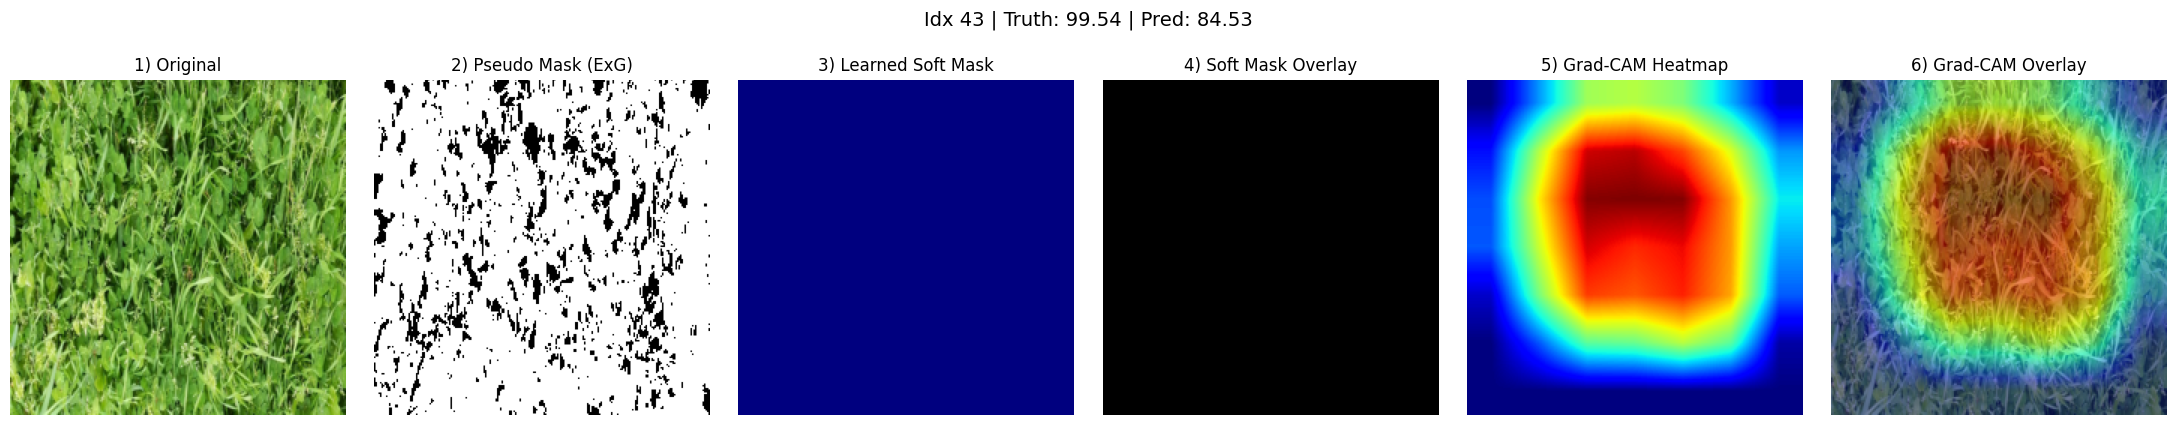


===== SoftMask =====


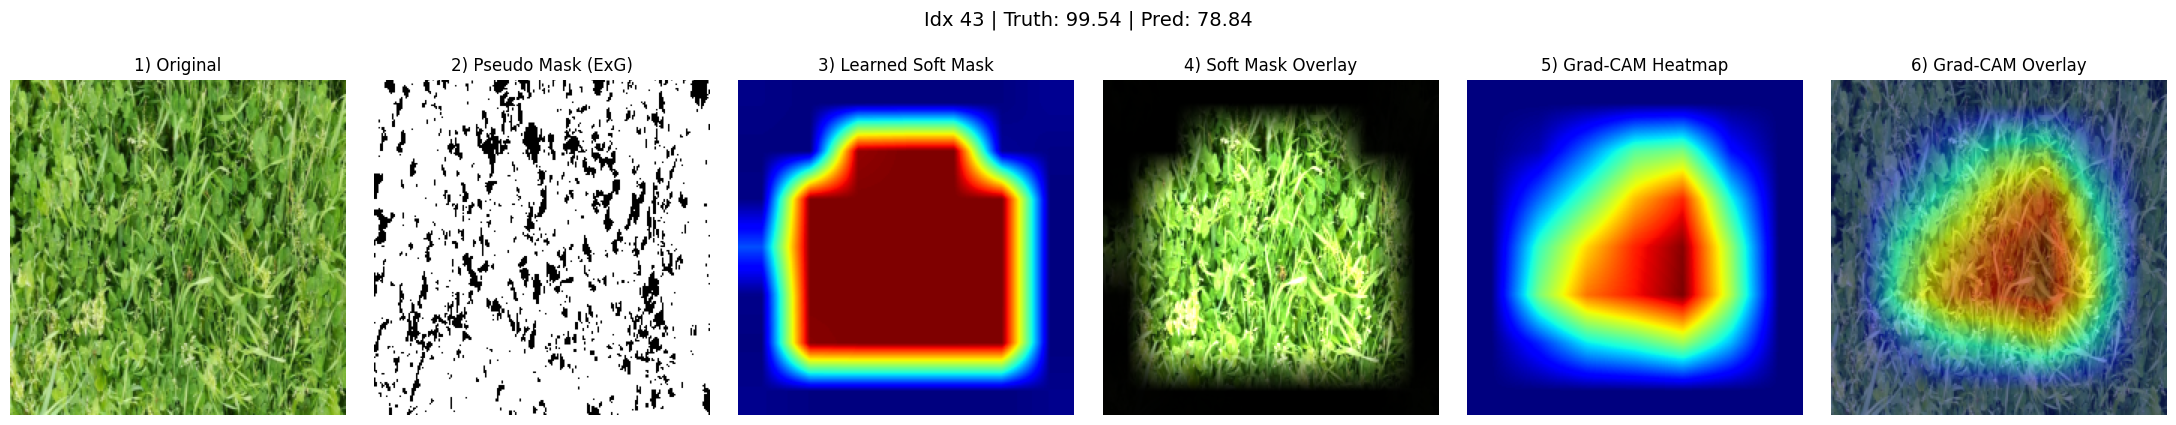


===== MTL =====


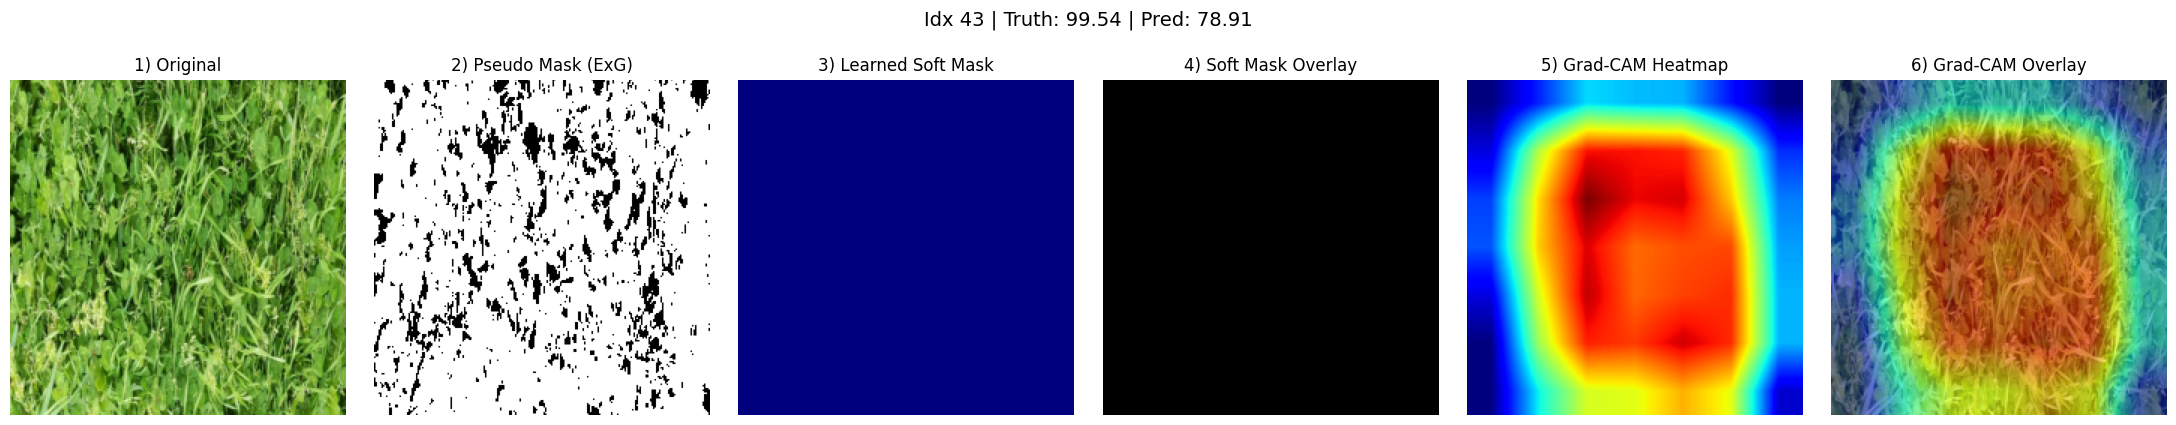


===== Full =====


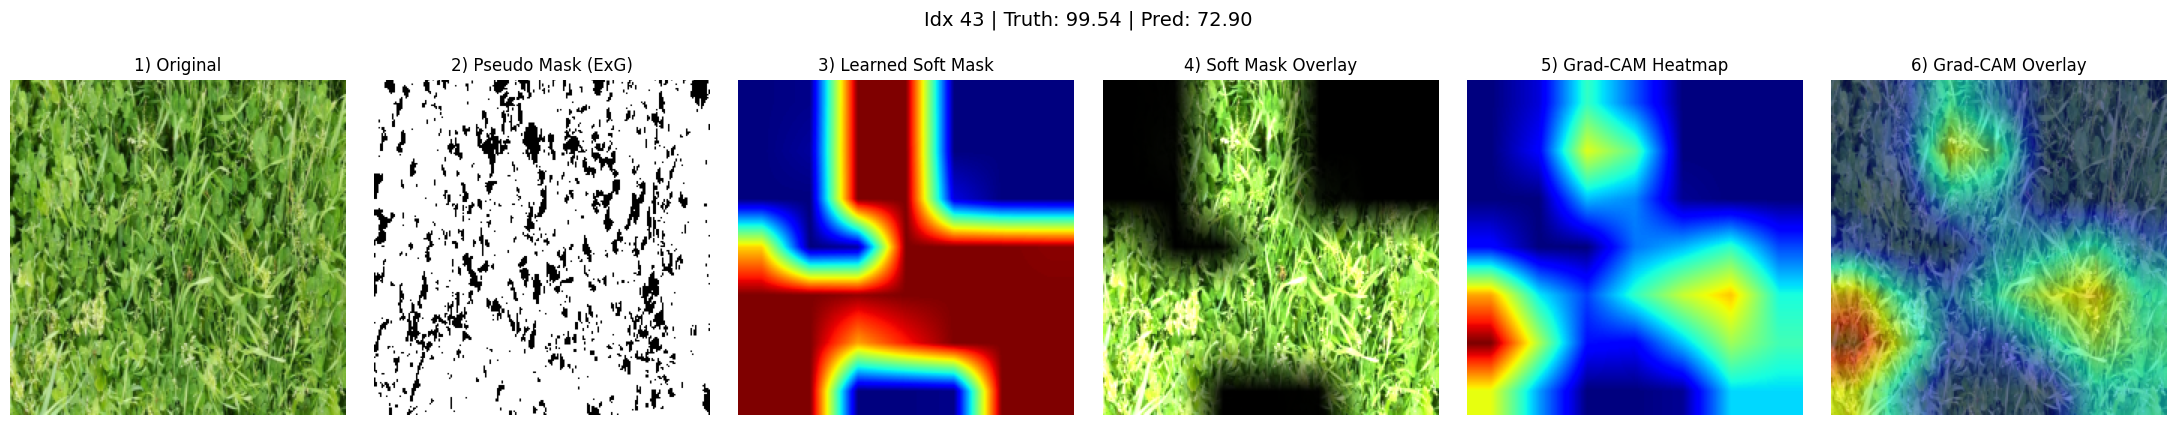

In [ ]:
import random
idx = random.randint(0, len(val_ds) - 1)
print(f"Random index for all models:", idx)

for name, m in [
    ("Baseline", model_base),
    ("SoftMask", model_soft),
    ("MTL", model_mtl),
    ("Full", model_full),
]:
    print(f"\n===== {name} =====")
    visualize_analysis_1x6(
        model=m,
        dataset=val_ds,
        idx=idx,
        device=DEVICE,
        target_col_idx=4
    )


In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(model_name, history, save=False):
    """
    繪製單一模型的 Loss / RMSE / R2 三圖
    """
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Loss
    axes[0].plot(epochs, history['train_loss'], label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], label='Val Loss')
    axes[0].set_title(f"{model_name} - Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("MSE Loss")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # RMSE
    axes[1].plot(epochs, history['val_rmse'], color='orange', label='Val RMSE')
    axes[1].set_title(f"{model_name} - RMSE")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("RMSE")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # R2
    axes[2].plot(epochs, history['val_r2'], color='green', label='Val R2')
    axes[2].axhline(0, color='red', linestyle='--', alpha=0.4)
    axes[2].set_title(f"{model_name} - R2 Score")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("R2")
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.suptitle(f"{model_name} Training Curves", fontsize=16)
    plt.tight_layout()

    if save:
        plt.savefig(f"{model_name}_training_curves.png", dpi=300)

    plt.show()


def plot_all_models_histories(
    hist_base, hist_soft, hist_mtl, hist_full,
    save=False
):
    """
    依序繪製四個模型的 Loss / RMSE / R2 曲線
    """
    print("Plotting all model histories...")

    plot_model_history("1. Baseline", hist_base, save=save)
    plot_model_history("2. Soft Mask", hist_soft, save=save)
    plot_model_history("3. MTL", hist_mtl, save=save)
    plot_model_history("4. Full (SMA + MTL)", hist_full, save=save)

    print("✔ All model curves plotted.")


📈 Plotting all model histories...


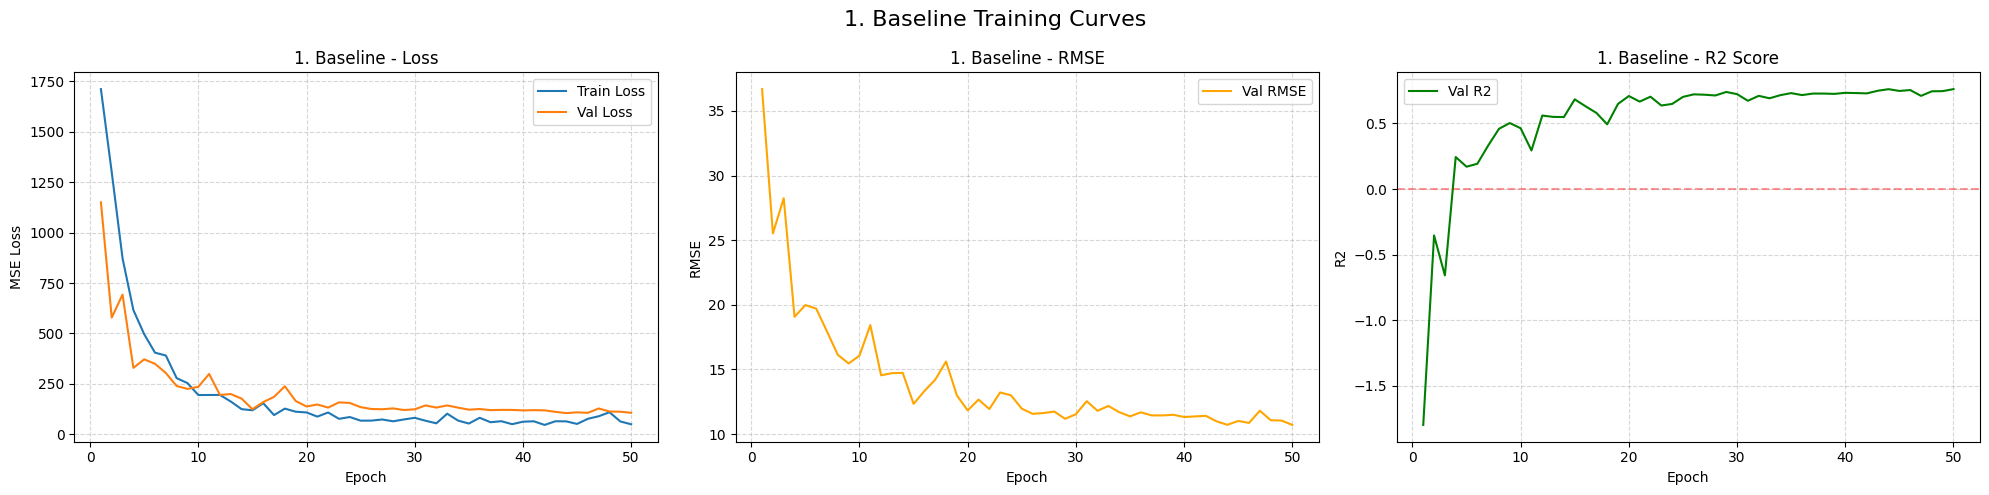

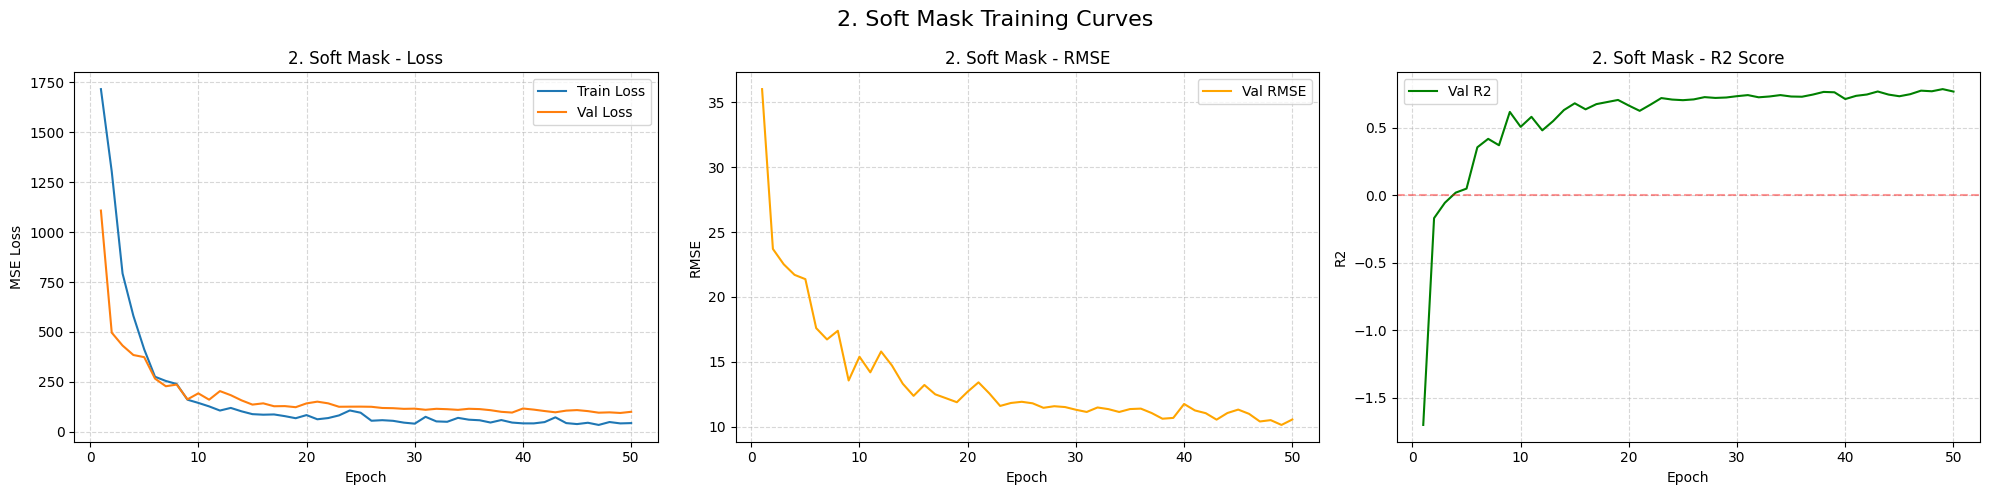

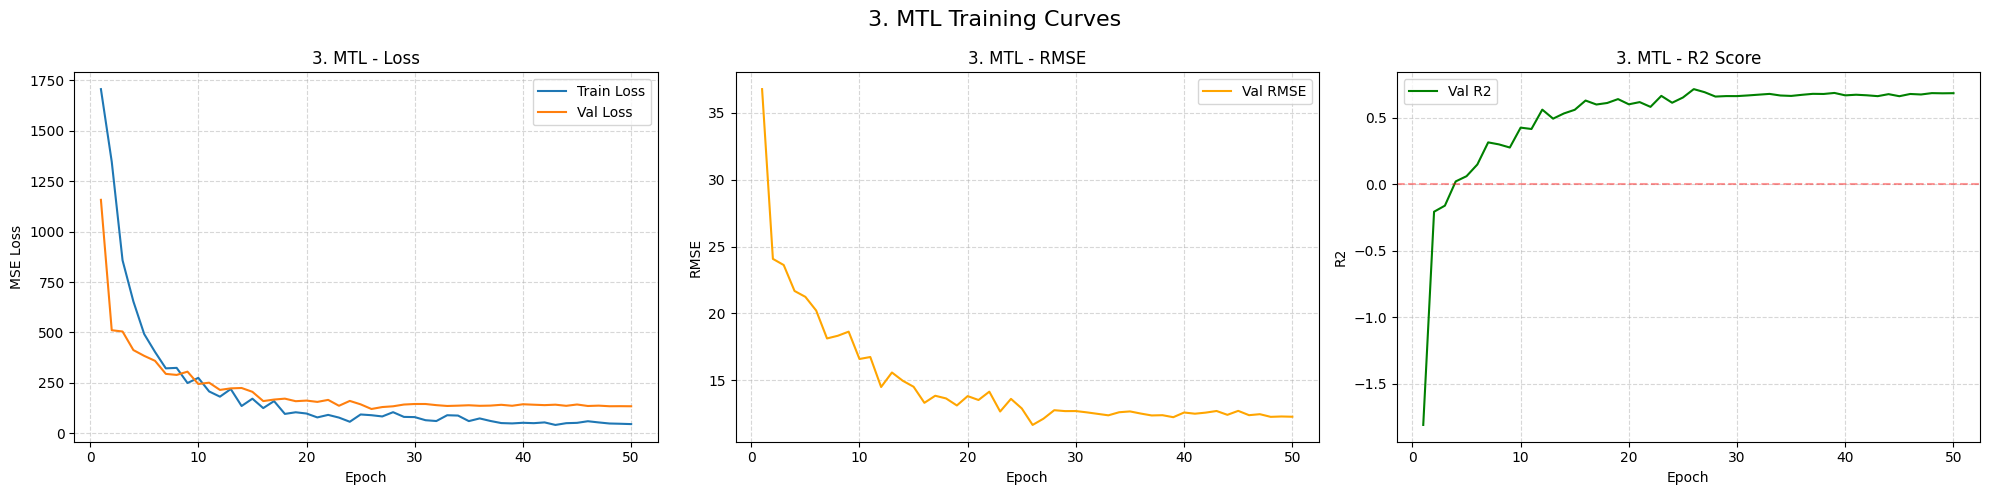

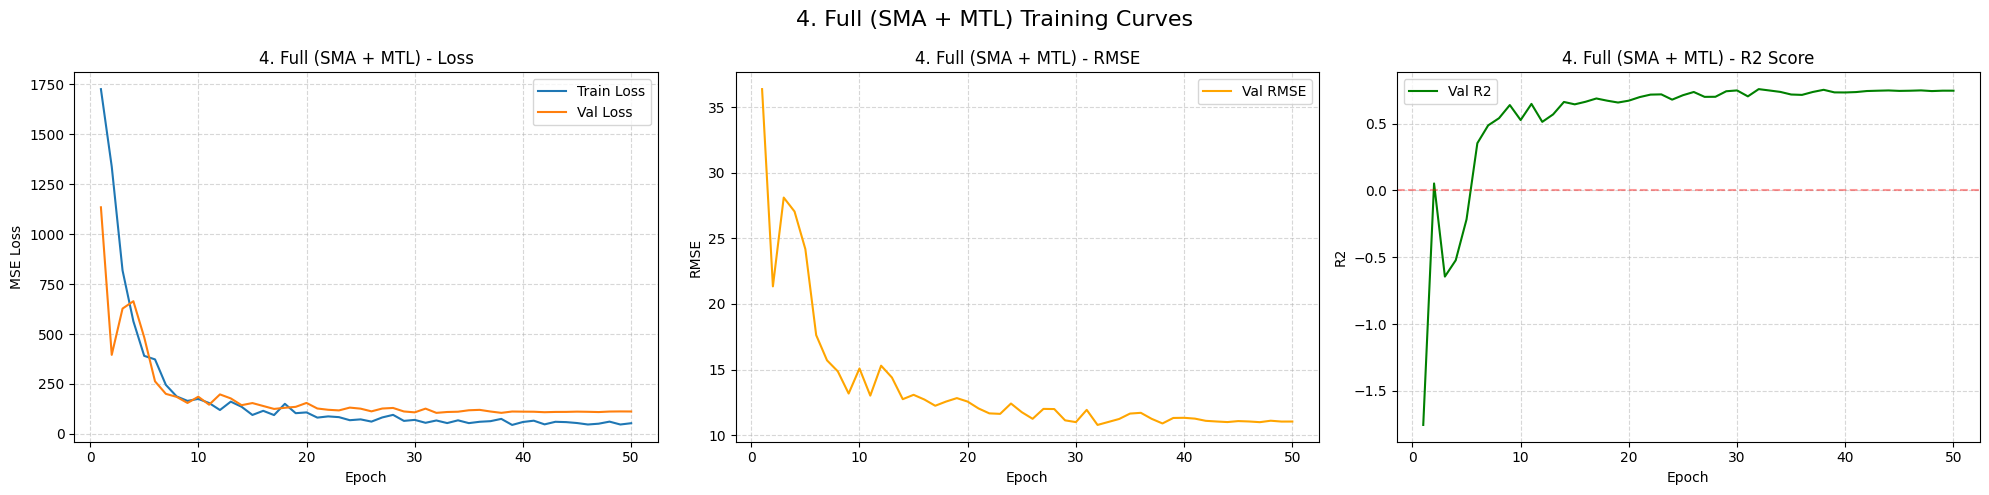

✔ All model curves plotted.


In [82]:
plot_all_models_histories(hist_base, hist_soft, hist_mtl, hist_full)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ==========================================
# 1. 輔助函式：反標準化 (用於顯示原始圖片)
# ==========================================
def inverse_normalize(tensor):
    """
    將 ImageNet 標準化後的 Tensor [3, H, W] 轉換回 0~1 之間的 Numpy RGB 圖片 [H, W, 3]
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img.astype(np.float32)

# ==========================================
# 2. 輔助函式：計算 Pseudo Mask (ExG)
# ==========================================
def compute_exg_mask_numpy(rgb_img_np):
    """
    計算 Excess Green (ExG) Index 並二值化作為 Pseudo Mask
    輸入: rgb_img_np (H, W, 3), 範圍 0~1
    輸出: mask (H, W), 範圍 0 或 1
    """
    r = rgb_img_np[:, :, 0]
    g = rgb_img_np[:, :, 1]
    b = rgb_img_np[:, :, 2]

    # ExG = 2g - r - b
    exg = 2 * g - r - b

    # Normalize ExG to 0-1 for thresholding
    exg_norm = (exg - exg.min()) / (exg.max() - exg.min() + 1e-8)

    # 簡單閾值處理 (可根據需求調整，例如 0.4 或 0.5)
    mask = (exg_norm > 0.4).astype(np.float32)
    return mask

# ==========================================
# 3. 輔助類別：Grad-CAM Wrapper
# ==========================================
class ModelWrapperForGradCAM(nn.Module):
    """Wrapper: 讓 Grad-CAM 只接收圖片，內部處理多輸出 + 指定 target_col_idx"""
    def __init__(self, model, target_col_idx=4):
        super().__init__()
        self.model = model
        self.target_col_idx = target_col_idx

    def forward(self, x):
        out = self.model(x)

        # 如果 forward 回傳 dict: {'pred': pred, 'soft_mask': ..., ...}
        if isinstance(out, dict):
            pred = out['pred']
        # 如果回傳 tuple: (pred, seg) 或 (pred, something)
        elif isinstance(out, tuple):
            pred = out[0]
        else:
            pred = out

        # 只回傳某一個 target 維度，讓 Grad-CAM 針對那一維做
        # pred 形狀通常是 [B, 5]
        if pred.ndim == 2 and pred.shape[1] > 1:
            pred = pred[:, self.target_col_idx:self.target_col_idx+1]

        return pred


In [ ]:
def visualize_1x6_analysis(model, dataset, idx, device, target_col_idx=4, target_layer=None):
    model.eval()
    model.to(device)

    # 1. 準備資料
    img_tensor, target_tensor = dataset[idx]
    img_input = img_tensor.unsqueeze(0).to(device) # [1, 3, H, W]
    H, W = img_tensor.shape[1], img_tensor.shape[2]

    # 取得真實標籤值
    true_val = target_tensor[target_col_idx].item()

    # ============================================
    # 2. 執行模型推論與獲取 Soft Mask
    # ============================================
    soft_mask_tensor = None
    pred_val = 0.0

    with torch.no_grad():
        # 假設模型 forward 有 return_viz 選項來回傳中間的 attention mask
        try:
            viz_out = model(img_input, return_viz=True)
            # 相容性處理：檢查回傳是字典還是 tuple
            if isinstance(viz_out, dict):
                prediction = viz_out['pred']
                soft_mask_tensor = viz_out.get('soft_mask') # 預期形狀 [1, 1, h, w] (例如 7x7)
            elif isinstance(viz_out, tuple):
                 # 如果您的模型設計是回傳 (pred, mask)
                prediction, soft_mask_tensor = viz_out
            else:
                prediction = viz_out
                print("警告: 模型未回傳 Soft Mask，將顯示全黑圖。")

            # Fixed: Use index 0 as n_outputs is 1 for GDM_g target.
            pred_val = prediction[0, 0].item()

        except TypeError:
            print("錯誤: 您的模型 forward 不支援 'return_viz=True'，請檢查模型定義。")
            return

    # ============================================
    # 3. 圖像處理與生成六張圖
    # ============================================

    # (1) Original Image
    original_img_np = inverse_normalize(img_tensor) # [H, W, 3], 0~1

    # (2) Pseudo Mask (ExG)
    pseudo_mask_np = compute_exg_mask_numpy(original_img_np) # [H, W], 0 or 1

    # (3) Learned Soft Mask
    if soft_mask_tensor is not None:
        # 將小的 mask (如 7x7) 插值放大到原始尺寸 (如 224x224)
        learned_mask_up = F.interpolate(soft_mask_tensor, size=(H, W), mode="bilinear", align_corners=False)
        learned_mask_np = learned_mask_up[0, 0].cpu().numpy()
        # 正規化到 0~1 以便顯示
        learned_mask_np = (learned_mask_np - learned_mask_np.min()) / (learned_mask_np.max() - learned_mask_np.min() + 1e-8)
    else:
        learned_mask_np = np.zeros((H, W), dtype=np.float32)

    # (4) Soft Mask Overlay (Img * Mask)
    # 將 mask 擴展為 [H, W, 1] 以便與 RGB 圖片相乘
    soft_overlay_np = original_img_np * learned_mask_np[:, :, None]
    # 增強亮度以便觀察 (可選)
    soft_overlay_np = np.clip(soft_overlay_np * 1.5, 0, 1)

    # (5) Grad-CAM Heatmap & (6) Overlay
    target_layer_found = False
    if target_layer is None:
        # 嘗試自動猜測常見的層名稱
        if hasattr(model, 'cnn') and hasattr(model.cnn, 'conv_head'):
            target_layer = model.cnn.conv_head
            target_layer_found = True
        elif hasattr(model, 'backbone') and hasattr(model.backbone, 'features'):
             target_layer = model.backbone.features[-1]
             target_layer_found = True
        else:
            print("錯誤: 請指定 target_layer 用於 Grad-CAM。")
    else:
        target_layer_found = True

    if target_layer_found:
        # 使用 Wrapper 確保 GradCAM 套件能正確處理模型輸出
        # Fixed: Pass target_col_idx to ModelWrapperForGradCAM
        model_wrapper = ModelWrapperForGradCAM(model, target_col_idx=target_col_idx)
        # Fixed: Remove 'use_cuda' argument
        cam = GradCAM(model=model_wrapper, target_layers=[target_layer])

        # Fixed: Always target index 0 for GradCAM since n_outputs is 1 for the specific target.
        targets = [ClassifierOutputTarget(0)]

        # 產生 Heatmap
        gradcam_heatmap = cam(input_tensor=img_input, targets=targets)[0] # [H, W], 0~1

        # 產生 Overlay
        gradcam_overlay = show_cam_on_image(original_img_np, gradcam_heatmap, use_rgb=True)
    else:
        gradcam_heatmap = np.zeros((H, W))
        gradcam_overlay = np.zeros((H, W, 3))

    # ============================================
    # 4. 繪製 1x6 圖表
    # ============================================
    fig, axes = plt.subplots(1, 6, figsize=(20, 3.5))

    # 定義要繪製的內容清單
    plots_config = [
        (original_img_np, "Original", None),
        (pseudo_mask_np, "Pseudo Mask (ExG)", "gray"),
        (learned_mask_np, "Learned Soft Mask", "jet"),
        (soft_overlay_np, "Soft Mask Overlay", None),
        (gradcam_heatmap, f"Grad-CAM Heatmap (T{target_col_idx})", "jet"),
        (gradcam_overlay, "Grad-CAM Overlay", None)
    ]

    for i, ax in enumerate(axes):
        img_data, title, cmap = plots_config[i]
        if cmap:
            ax.imshow(img_data, cmap=cmap, vmin=0, vmax=1)
        else:
            ax.imshow(img_data)
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.suptitle(f"Image Index: {idx} | True Val: {true_val:.2f} | Pred Val: {pred_val:.2f}", fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

Visualizing index: 20


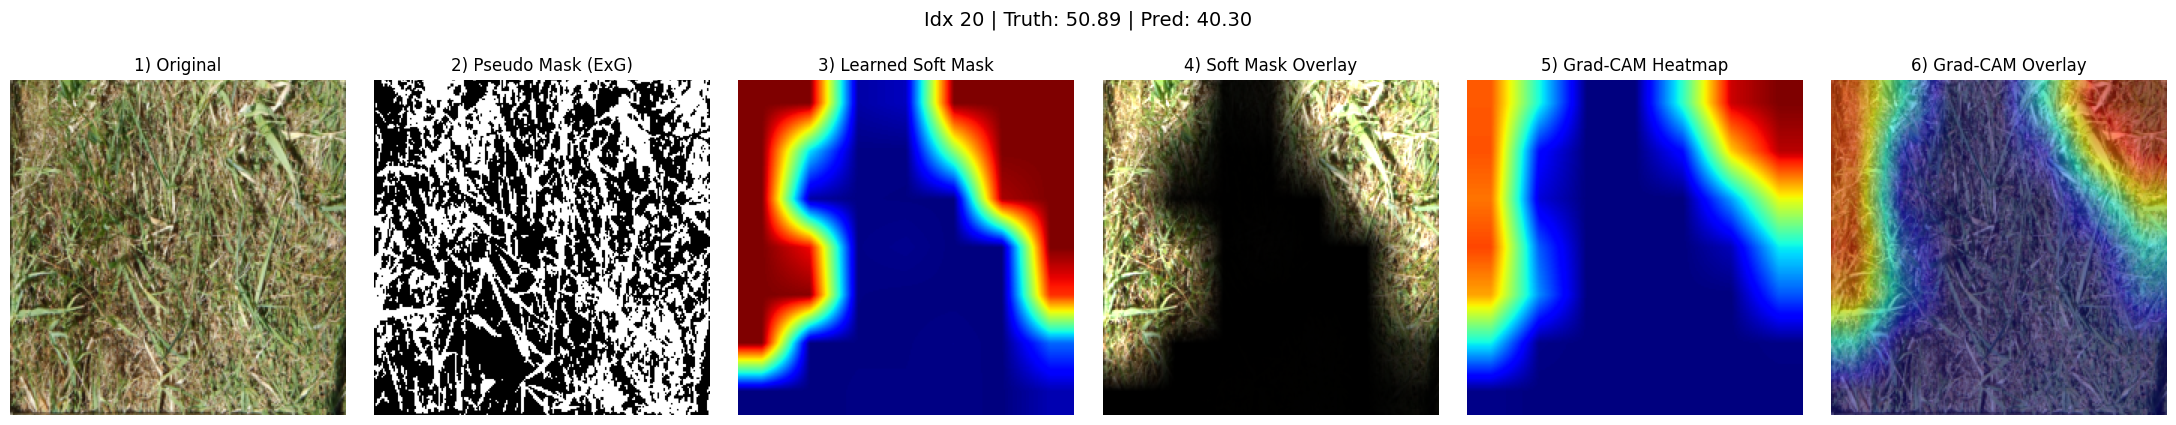

In [119]:
# 1. 確保使用正確的模型變數名稱
if 'model_full' in locals():
    model = model_full
else:
    raise NameError("找不到 'model_full'，請確認您已執行模型定義與載入的程式碼。")

# 2. 隨機挑選一個索引
import random
# 確保使用正確的驗證集變數名稱 (根據之前的紀錄是 val_ds)
dataset_to_use = val_ds if 'val_ds' in locals() else val_dataset
idx = random.randint(0, len(dataset_to_use) - 1)

print(f"Visualizing index: {idx}")

# 3. 執行視覺化 (使用上一段定義的正確函式名稱 visualize_analysis_1x6)
# 注意：不需要傳入 target_layer，函式內部會自動尋找 model.cnn.conv_head
visualize_analysis_1x6(
    model=model,
    dataset=dataset_to_use,
    idx=idx,
    device=DEVICE,
    target_col_idx=4
)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """
    繪製 Loss, RMSE, R2 三張圖表
    history: 包含 'train_loss', 'val_loss', 'val_rmse', 'val_r2' 的字典
    """
    # 確保 history 是字典格式 (若使用自定義 class 回傳可能需要轉換)
    # 建立 x 軸 (Epochs 1 ~ N)
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(20, 5))

    # ---------------------------
    # 1. Loss 圖 (MSE)
    # ---------------------------
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', markersize=4)
    plt.plot(epochs_range, history['val_loss'], label='Val Loss', marker='o', markersize=4)
    plt.title('Loss (MSE) Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # ---------------------------
    # 2. RMSE 圖
    # ---------------------------
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['val_rmse'], label='Val RMSE', color='orange', marker='o', markersize=4)
    plt.title('Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # ---------------------------
    # 3. R2 Score 圖
    # ---------------------------
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['val_r2'], label='Val R2', color='green', marker='o', markersize=4)

    # 加入參考線 (0 和 1)
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.3, label='Perfect (1.0)')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.3, label='Baseline (0.0)')

    plt.title('Validation R2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 自動調整間距並顯示
    plt.tight_layout()
    plt.show()

if 'history' in locals() and history['train_loss']:
    plot_training_metrics(history)
else:
    print("尚未找到 history 變數，請先執行訓練流程。")

尚未找到 history 變數，請先執行訓練流程。


In [92]:
import torch
from prettytable import PrettyTable

def analyze_model_parameters():
    # 1. 定義四種實驗配置 (名稱, use_soft_mask, use_mtl)
    configs = [
        ("Baseline", False, False),
        ("Soft Mask", True, False),
        ("MTL", False, True),
        ("PastureMask-MTLNet", True, True)
    ]

    # 2. 設定表格外觀
    table = PrettyTable()
    table.field_names = ["Model Variant", "Soft Mask", "MTL", "Total Params", "Delta (%)"]

    # 設定對齊方式 (文字靠左，數字靠右)
    table.align["Model Variant"] = "c"
    table.align["Soft Mask"] = "c"
    table.align["MTL"] = "c"
    table.align["Total Params"] = "r"
    table.align["Delta (%)"] = "r"

    # 用來儲存基準 (Baseline) 的參數量
    baseline_params = 0

    print("=== Ablation Study: Model Parameter Analysis ===")

    for idx, (name, use_mask, use_mtl) in enumerate(configs):
        # 3. 實例化模型 (確保 PastureAblationModel 類別已定義)
        # 這裡的 n_outputs=5 僅為示例，不影響總參數量
        model = PastureAblationModel(n_outputs=1, use_soft_mask=use_mask, use_mtl=use_mtl)

        # 4. 計算可訓練參數總數 (Trainable Parameters)
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        # 5. 計算 Delta (%)
        if idx == 0:
            baseline_params = total_params
            delta_str = "0.00%"
        else:
            delta = (total_params - baseline_params) / baseline_params * 100
            # 格式化: 正號, 兩位小數
            delta_str = f"+{delta:.2f}%"

        # 6. 設定顯示符號 (✔ / ✘)
        mask_symbol = "✔" if use_mask else "✘"
        mtl_symbol = "✔" if use_mtl else "✘"

        # 7. 加入表格列 (加上千分位逗號 "{:,}")
        table.add_row([name, mask_symbol, mtl_symbol, f"{total_params:,}", delta_str])

    # 印出表格
    print(table)

    # 8. 印出分析指引 (完全復刻圖片內容)
    print("\n[Analysis Guide]")
    print("1. Soft Mask 增加的參數量非常少 (僅 2 個 1x1 Conv)，但能顯著提升特徵聚焦能力。")
    print("2. MTL Decoder 雖然增加參數，但在推論階段(Inference)可以移除，不影響預測速度。")
    print("3. PastureMask-MTLNet 結合兩者，以極小的代價換取效能提升。")

# --- 執行分析 ---
# 請確保 PastureAblationModel 類別已經在記憶體中
analyze_model_parameters()

=== Ablation Study: Model Parameter Analysis ===
+--------------------+-----------+-----+--------------+-----------+
|   Model Variant    | Soft Mask | MTL | Total Params | Delta (%) |
+--------------------+-----------+-----+--------------+-----------+
|      Baseline      |     ✘     |  ✘  |    4,335,741 |     0.00% |
|     Soft Mask      |     ✔     |  ✘  |    4,438,302 |    +2.37% |
|        MTL         |     ✘     |  ✔  |   10,268,702 |  +136.84% |
| PastureMask-MTLNet |     ✔     |  ✔  |   10,371,263 |  +139.20% |
+--------------------+-----------+-----+--------------+-----------+

[Analysis Guide]
1. Soft Mask 增加的參數量非常少 (僅 2 個 1x1 Conv)，但能顯著提升特徵聚焦能力。
2. MTL Decoder 雖然增加參數，但在推論階段(Inference)可以移除，不影響預測速度。
3. PastureMask-MTLNet 結合兩者，以極小的代價換取效能提升。


In [121]:
import numpy as np

def print_best_result(model_name, history):
    """
    幫某一個 model 印出：
    - 最佳 RMSE 及其所在 epoch
    - 最佳 R2 及其所在 epoch
    """
    best_rmse = float(np.min(history['val_rmse']))
    best_rmse_epoch = int(np.argmin(history['val_rmse'])) + 1  # epoch 從 1 開始

    best_r2 = float(np.max(history['val_r2']))
    best_r2_epoch = int(np.argmax(history['val_r2'])) + 1

    print(f"{model_name}:")
    print(f"  ▸ Best RMSE = {best_rmse:.4f}  (epoch {best_rmse_epoch})")
    print(f"  ▸ Best R2   = {best_r2:.4f}  (epoch {best_r2_epoch})")
    print()

print("\n=== Best Results of Each Model ===")
print_best_result("Baseline",          hist_base)
print_best_result("Soft Mask",         hist_soft)
print_best_result("MTL",               hist_mtl)
print_best_result("Full (SMA + MTL)",  hist_full)


=== Best Results of Each Model ===
Baseline:
  ▸ Best RMSE = 10.7024  (epoch 50)
  ▸ Best R2   = 0.7618  (epoch 50)

Soft Mask:
  ▸ Best RMSE = 10.1291  (epoch 49)
  ▸ Best R2   = 0.7867  (epoch 49)

MTL:
  ▸ Best RMSE = 11.6803  (epoch 26)
  ▸ Best R2   = 0.7163  (epoch 26)

Full (SMA + MTL):
  ▸ Best RMSE = 10.7692  (epoch 32)
  ▸ Best R2   = 0.7588  (epoch 32)

